In [1]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from scipy import stats

from multiprocessing import cpu_count

# Subsampling

**Unbalanced problems** are those classification problems where the ratio between the different classes is significantly different. These problems have some special issues that make them a little bit more difficult to solve. In particular, the choice of metric should account for this class imbalance, and some extra steps should be carried out to avoid the model focusing too much on the most frequent classes and performing poorly over the least frequent ones.

We will focus here on the binary classification problem, where you have a **majority class** and a **minority class**. For instance, the healthcare classification problem we worked on previous classes could be considered an unbalanced problem as the ratio of exitus (minority class) is approximately 5%. Other example would be the fraud detection problem at Iberia Express, where the minority class (fraud transaction) never exceeds 0.2% of the data, which is a ratio that would be considered a real unbalanced classification problem.

Metrics that can be applied to unbalanced problems are the ones based on the area under a curve. We have already seen ROC curve and precision-recall curve. From this two, area under the precision-recall curve is slightly preferred when dealing with highly unbalanced problems.

Regarding the extra pre-processing steps that can be carried out to help model solve unbalanced problems, we will cover **oversampling** of the minority class and **subsampling** of the majority class. We focus here on subsampling.

## Load Data

In [2]:
dat = pd.read_csv('../data/healthcare.csv', sep = ";")
dat = dat.drop(['date', 'severity', 'origin', 'tip_grd', 'tip_adm'], axis = 1) # Remove non-numerical variables for this notebook
dat

,mortality_ratio,age,num_proc,ambulatory,expected_length,exitus
0,0.408730,12596,21,0,151,0
1,0.306931,20973,22,0,99,0
2,0.278481,19611,19,0,87,0
3,0.150289,13583,22,0,100,0
4,0.016573,18042,2,0,44,0
...,...,...,...,...,...,...
32701,0.028365,23619,2,0,2,0
32702,0.000606,3935,1,0,2,0
32703,0.040452,30163,4,0,2,0
32704,0.000000,29012,4,0,0,0


In [3]:
100*dat.groupby(['exitus'])['exitus'].agg(['count'])/dat.shape[0]

,count
exitus,
0,96.159726
1,3.840274


This can be considered an unbalanced classification problem. Let's see how to apply undersampling to it.

## Random Subsampling

One straightforward way of decreasing the majority class examples is to just randomly remove examples of this class from the dataset.

This can easily done with numpy choice function.

In [4]:
subsampling_rows = np.random.choice(dat[dat['exitus'] == 0].index,
                                    int(0.5*dat.shape[0]),
                                   replace = False)
subsampling_rows.shape

(16353,)

In [5]:
dat_random_subsampling = dat.drop(subsampling_rows)

In [6]:
dat['exitus'].value_counts()

exitus
0    31450
1     1256
Name: count, dtype: int64

In [7]:
dat_random_subsampling['exitus'].value_counts()

exitus
0    15097
1     1256
Name: count, dtype: int64

In [8]:
100*dat_random_subsampling.groupby(['exitus'])['exitus'].agg(['count'])/dat_random_subsampling.shape[0]

,count
exitus,
0,92.319452
1,7.680548


We have reduced the target unbalance.

## Condensed Nearest Neighbors

This method remove instances from the majority class fulfilling:



- Get all minority samples in a set C.


- Add a sample from the majority class (class to be under-sampled) in C and all other samples of this class in a set S.


- Go through the set S, sample by sample, and classify each sample using a 1 nearest neighbor rule.


- If the sample is misclassified, add it to C, otherwise do nothing.


- Reiterate on S until there is no samples to be added.


It is available in the package *imbalanced-learn*.

In [9]:
from imblearn.under_sampling import CondensedNearestNeighbour

In [10]:
cnn = CondensedNearestNeighbour(sampling_strategy = 'majority')

In [11]:
X_cnn, y_cnn = cnn.fit_resample(dat.drop('exitus', axis = 1).fillna(0),
                                dat['exitus'])

In [ ]:
dat_cnn = pd.concat([X_cnn, y_cnn], axis = 1)

In [ ]:
100*dat_cnn.groupby(['exitus'])['exitus'].agg(['count'])/dat_cnn.shape[0]

,count
sales channel,
call center,20.207254
online,79.792746


In [ ]:
dat['sales channel'].value_counts()

online         624
call center     39
Name: sales channel, dtype: int64

In [ ]:
dat_cnn['sales channel'].value_counts()

online         154
call center     39
Name: sales channel, dtype: int64

## Model Example

Let's work now with an artificial dataset.

In [ ]:
?make_classification

Object `make_classification` not found.


In [ ]:
from sklearn.datasets import make_classification

In [ ]:
X, y = make_classification(FILL)

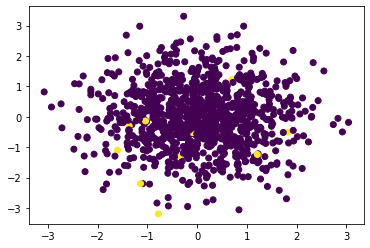

In [ ]:
# scatter plot of examples by class label
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.show()

In [ ]:
unique, counts = np.unique(y, return_counts=True);
print(np.asarray((unique, counts)).T);

[[  0 990]
 [  1  10]]


Let's apply CNN undersamling over this dataset.

In [ ]:
cnn = CondensedNearestNeighbour(FILL)

In [ ]:
X_cnn, y_cnn = cnn.fit_resample(FILL)

In [ ]:
unique, counts = np.unique(y_cnn, return_counts=True);
print(np.asarray((unique, counts)).T);

[[ 0 83]
 [ 1 10]]


And build models with and without undersampling.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=1);
X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X_cnn, y_cnn, stratify = y_cnn, test_size=0.3, random_state=1);


Model without undersampling

In [ ]:
FILL

Model with undersampling

In [ ]:
FILL

In [ ]:
# print error
print('AUC train = %.2f - AUC test = %.2f'
      % (metric_train, metric_test))

# print error
print('AUC undersampling train = %.2f - AUC undersampling test = %.2f'
      % (metric_cnn_train, metric_cnn_test))

AUC train = 1.00 - AUC test = 0.63


## Define Custom Function

Let's create our own custom function to apply undersampling.

In [18]:
def undersampling(X, y,type_value = 'cnn', p = 0.5, k = 1, n_jobs = 1):
    if type_value == 'cnn':
        cn = CondensedNearestNeighbour(sampling_strategy = 'majority',
           n_neighbors = k,
           n_jobs = n_jobs)
        X, y = cn.fit_resample(X, y)
        return X,y
    elif type_value == 'random':
        majority_class = stats.mode(y)[0][0]
        subsampling_rows = np.random.choice(np.arange(0, len(y[y == majority_class])),
                                            int(p*len(y[y == majority_class])),
                                           replace = False)
        X = np.delete(X, subsampling_rows, axis=0)
        y = np.delete(y, subsampling_rows, axis=0)
        return X,y


In [ ]:
X_new, y_new = undersampling(X, y)
X_new.shape

(87, 20)

In [ ]:
X_new, y_new = undersampling(X, y, p = 0.25, type_value = 'random')
X_new.shape

(258, 20)

## Other Undersampling Techniques

There are variations of SMOTE available on the package


- Random majority under-sampling with replacement


- Extraction of majority-minority Tomek links


- Under-sampling with Cluster Centroids


- NearMiss-(1 & 2 & 3)


- One-Sided Selection


- Neighboorhood Cleaning Rule


- Edited Nearest Neighbours


- Instance Hardness Threshold


- Repeated Edited Nearest Neighbours


- AllKNN






Reference: https://github.com/scikit-learn-contrib/imbalanced-learn